<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://)# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
!pip install setuptools==64.0.2
!apt-get install swig
!pip install wrds
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (4.0.1-5build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-b11n7l2v
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-b11n7l2v
  Resolved https://github.com/AI4Finance-LLC/FinRL-Library.git to commit 72afbdd62f6f784e7562477276f16abd70d36ed5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning http


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [ ]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [170]:
TRAIN_START_DATE = '2015-01-28'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-02'
TEST_END_DATE = '2023-04-01'

#df = YahooDownloader(start_date = TRAIN_START_DATE,
                     #end_date = TEST_END_DATE,
                     #ticker_list = DOW_30_TICKER).fetch_data()

df = pd.read_csv("https://utdallas.box.com/shared/static/sori885zobj8y0mtxqpy2f9e1agfrzlr.csv")

df["Date"] = pd.to_datetime(df['Date'])
#df["Date"] = df["date"]
df = df.rename(columns={'Date': 'date', 
                        'Open': 'open', 
                        'High': 'high',	
                        'Low': 'low',
                        'Close': 'close',	
                        'Adj Close': 'adj close', 
                        'Volume': 'volume'})
df['tic'] = "SPY"
train = df[(df['date'] >= TRAIN_START_DATE) & (df['date'] < TRAIN_END_DATE)]
test = df[(df['date'] >= TEST_START_DATE) & (df['date'] < TEST_END_DATE)]
train

,date,open,high,low,close,adj close,volume,tic
5539,2015-01-28,204.169998,204.289993,199.910004,200.139999,172.236404,168514300,SPY
5540,2015-01-29,200.380005,202.300003,198.679993,201.990005,173.828537,173585400,SPY
5541,2015-01-30,200.570007,202.169998,199.130005,199.449997,171.642593,197729700,SPY
5542,2015-02-02,200.050003,202.029999,197.860001,201.919998,173.768280,163107000,SPY
5543,2015-02-03,203.000000,204.850006,202.550003,204.839996,176.281143,124212900,SPY
...,...,...,...,...,...,...,...,...
7028,2020-12-24,368.079987,369.029999,367.450012,369.000000,356.970245,26457900,SPY
7029,2020-12-28,371.739990,372.589996,371.070007,372.170013,360.036957,39000400,SPY
7030,2020-12-29,373.809998,374.000000,370.829987,371.459991,359.350067,53680500,SPY
7031,2020-12-30,372.339996,373.100006,371.570007,371.989990,359.862823,49455300,SPY


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

IDICATORS -
* **MACD**- Moving Avg Convergence divergence 
* **RSI**- Relative Strength Index
* **CCI**- Commoditiy Channel Index
* **DX**- Directional Movement Index                 

In [171]:
INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

In [172]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = True)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features


In [173]:
processed.sample(5)

,date,open,high,low,close,adj close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence,daily_return
5400,2014-07-10,195.220001,196.860001,195.059998,196.339996,167.256927,99040000,SPY,1.185610,58.745838,51.770871,2.842712,0.533737,-0.003957
968,1996-11-26,76.281250,76.687500,75.468750,75.875000,47.409416,2861800,SPY,1.358783,72.590424,143.884892,78.042399,0.280075,-0.003284
7163,2021-07-12,435.429993,437.350006,434.970001,437.079987,425.603516,52889600,SPY,4.118772,63.727772,181.273318,30.838828,0.056162,0.003582
7601,2023-04-06,406.769989,409.480011,405.679993,409.190002,409.190002,63743300,SPY,2.908064,55.164273,131.162510,16.942822,0.083134,0.003901
3213,2005-10-28,118.430000,119.949997,118.099998,119.800003,85.253487,72322000,SPY,-0.616410,48.069128,-36.305912,7.464698,4.685120,0.014395


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [174]:
stock_dimension = len(processed.tic.unique())
stock_dimension
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 7


In [175]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [176]:
rebalance_window = 63 #63 # rebalance_window is the number of days to retrain the model
validation_window = 63 #63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [177]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2, #2048
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 1, #10_000
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 1, #10_000 each
                 'ppo' : 1, 
                 'ddpg' : 1
                 }

In [178]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  20.246110445177994
======Model training from:  2015-01-28 to  2021-01-04T00:00:00.000000000
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_8
======A2C Validation from:  2021-01-04T00:00:00.000000000 to  2021-04-06T00:00:00.000000000
A2C Sharpe Ratio:  0.32562201704488214
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to tensorboard_log/ppo/ppo_126_8
----------------------------
| time/              |     |
|    fps             | 126 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 2   |
| train/             |     |
|    reward          | 0.0 |
----------------------------
======PPO Validation from:  2021-01-04T00:00:00.000000000 to  2021-04-06T00:00:00.000000000
PPO Sharpe Ratio:  0.08351822251022775
=====

Evaluate 3 models: 
```
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_2
======A2C Validation from:  2021-01-04 to  2021-04-06
A2C Sharpe Ratio:  0.385380425496823
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to tensorboard_log/ppo/ppo_126_2
------------------------------------
| time/              |             |
|    fps             | 70          |
|    iterations      | 1           |
|    time_elapsed    | 0           |
|    total_timesteps | 2           |
| train/             |             |
|    reward          | 0.040208012 |
------------------------------------
```
```
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to tensorboard_log/ppo/ppo_189_2
------------------------------------
| time/              |             |
|    fps             | 68          |
|    iterations      | 1           |
|    time_elapsed    | 0           |
|    total_timesteps | 2           |
| train/             |             |
|    reward          | 0.040100437 |
------------------------------------
======PPO Validation from:  2021-04-06 to  2021-07-06
PPO Sharpe Ratio:  0.11003721348304311
```


------------------------------------

In [179]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-01-04,2021-04-06,A2C,0.325622,0.083518,0.0
1,189,2021-04-06,2021-07-06,A2C,0.261405,0.128182,0.227914
2,252,2021-07-06,2021-10-04,DDPG,-0.526312,-0.337788,-0.03848
3,315,2021-10-04,2022-01-03,A2C,0.256991,0.205197,0.247058
4,378,2022-01-03,2022-04-04,A2C,0.113002,-0.502097,-0.006647
5,441,2022-04-04,2022-07-06,PPO,-0.312702,-0.049202,-0.23353
6,504,2022-07-06,2022-10-04,DDPG,-0.033409,-0.311455,0.0


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [180]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [181]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.45280088114304584


In [182]:
df_account_value.head()
df_account_value.tail()

,account_value,date,daily_return,datadate
436,860707.099575,2022-12-27,0.0,2022-12-27
437,860707.099575,2022-12-28,0.0,2022-12-28
438,860707.099575,2022-12-29,0.0,2022-12-29
439,860707.099575,2022-12-30,0.0,2022-12-30
440,860707.099575,2023-01-03,0.0,2023-01-03


<Axes: >

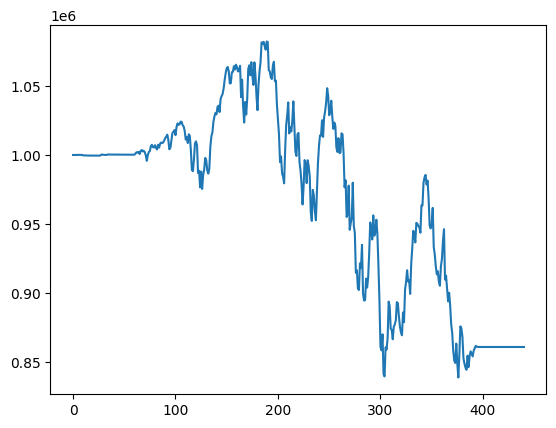

In [183]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [184]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.082144
Cumulative returns    -0.139293
Annual volatility      0.161033
Sharpe ratio          -0.452801
Calmar ratio          -0.364762
Stability              0.588739
Max drawdown          -0.225199
Omega ratio            0.914507
Sortino ratio         -0.605517
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.953832
Daily value at risk   -0.020578
dtype: float64


In [185]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="SPY", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)
Annual return         -0.019306
Cumulative returns    -0.033465
Annual volatility      0.199600
Sharpe ratio           0.001789
Calmar ratio          -0.078810
Stability              0.277321
Max drawdown          -0.244964
Omega ratio            1.000303
Sortino ratio          0.002504
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.994600
Daily value at risk   -0.025146
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot


#Part 8: Deploy model 

In [186]:
!pip install alpaca
!pip install alpaca-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 8)


Start date,2021-04-06
End date,2023-01-03
Total months,21
,Backtest
Annual return,-8.214%
Cumulative returns,-13.929%
Annual volatility,16.103%
Sharpe ratio,-0.45
Calmar ratio,-0.36
Stability,0.59
Max drawdown,-22.52%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.52,2022-01-03,2022-09-30,NaT,NaN
1,4.77,2021-09-02,2021-10-04,2021-10-20,35
2,3.94,2021-11-18,2021-12-01,2021-12-10,17
3,3.26,2021-12-10,2021-12-20,2021-12-23,10
4,1.13,2021-11-08,2021-11-10,2021-11-16,7


Stress Events,mean,min,max
New Normal,-0.03%,-3.87%,3.04%


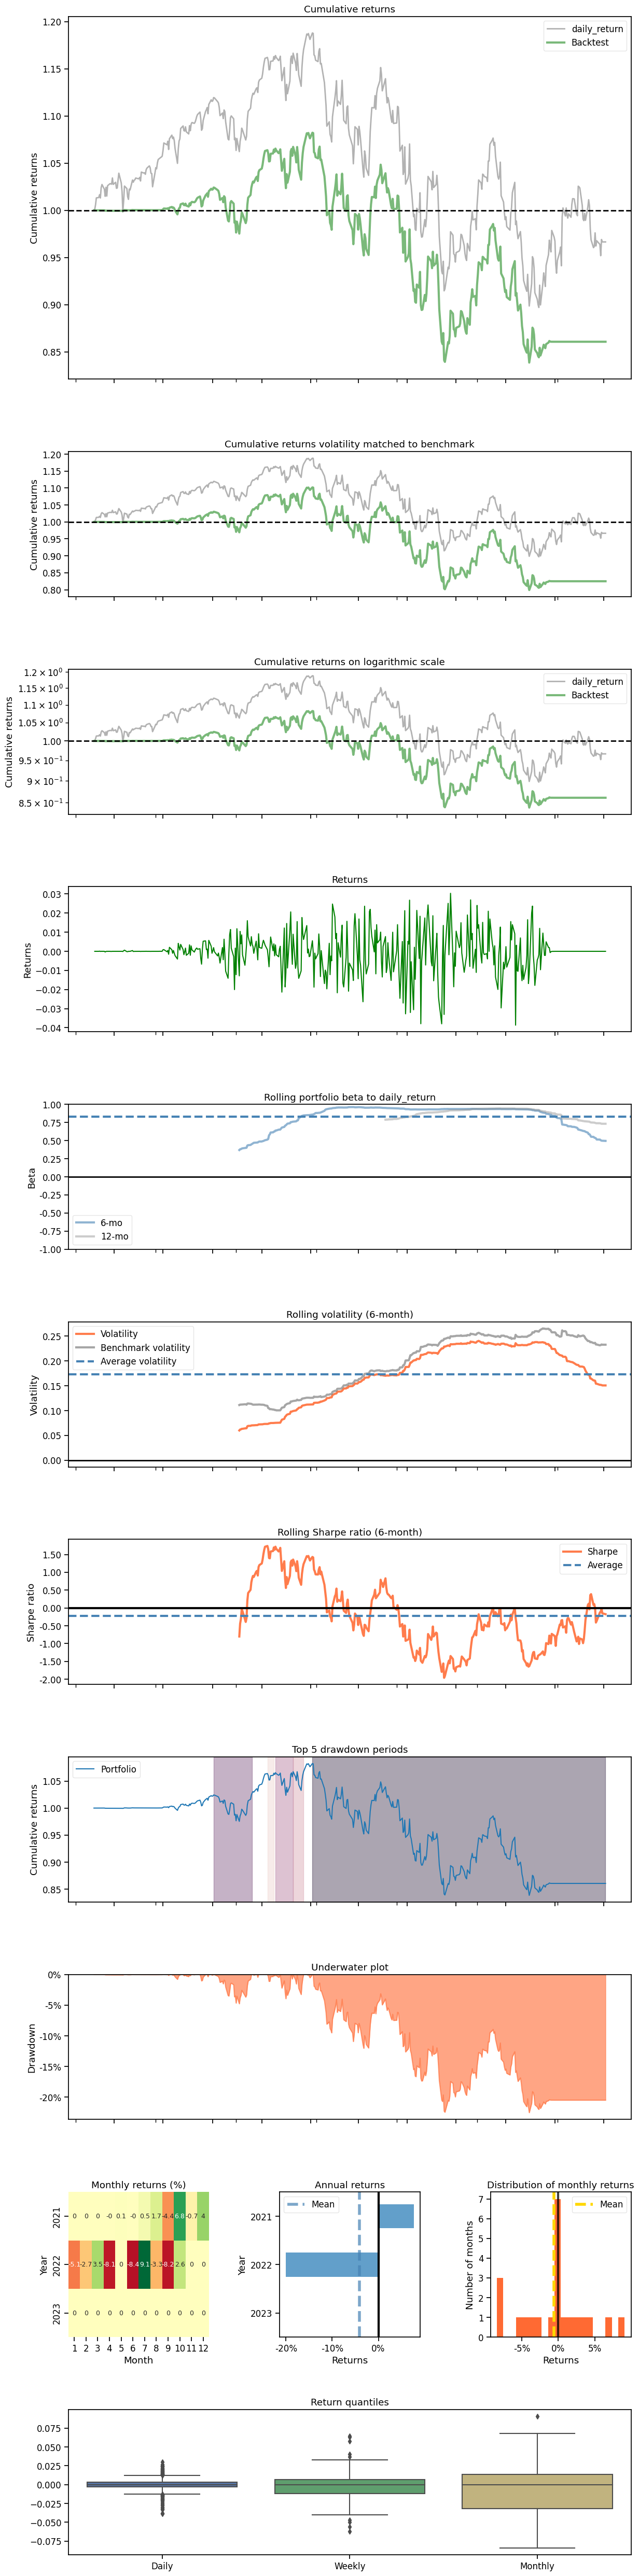

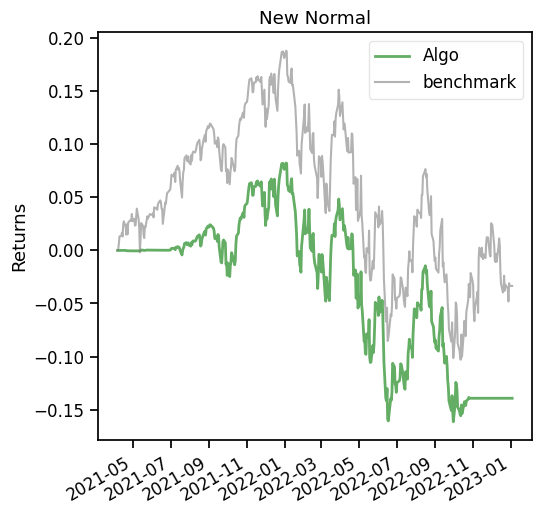

In [187]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = 'SPY', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [188]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import datetime as datetime
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import LimitOrderRequest
# #I make a cryptocurrency trading bot and hand it a $1000 dollars and leave it to trade that unsupervised for a week.

key = "PKH1TEUVQBLVWUUYRTZY"
secret_key = 'wb5RSe3o52ZfNUSsltI3IEaV8SLVzGi42qRgTBhG'
trading_client = TradingClient(key, secret_key, paper=True)


##Market Order 
# preparing orders
market_order_data = MarketOrderRequest(
                    symbol="NVDA",
                    qty=1,
                    side=OrderSide.SELL,
                    time_in_force=TimeInForce.DAY
                    )

# Market order
market_order = trading_client.submit_order(
                order_data=market_order_data
               )

